/var/folders/g2/h96jw1g13rlbjmy05t0vgn800000gn/T/ipykernel_15245/610733383.py:107: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/sarahdavidson/posner_quantum_dynamics/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


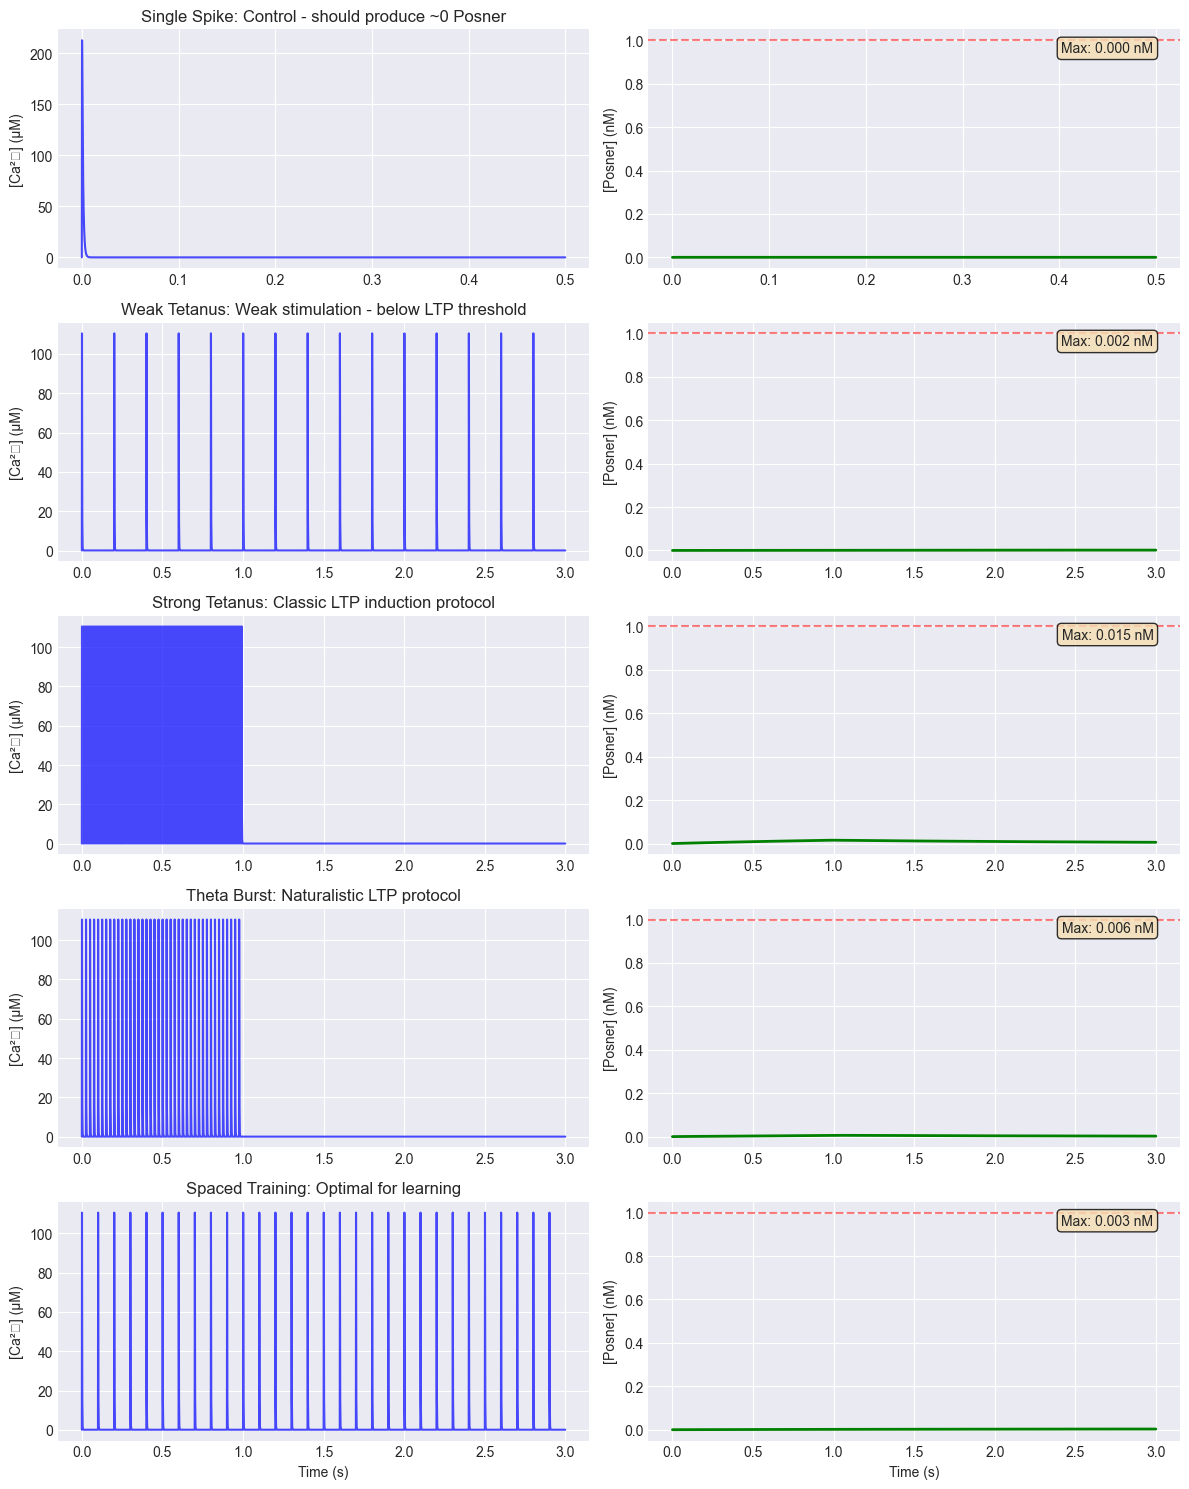

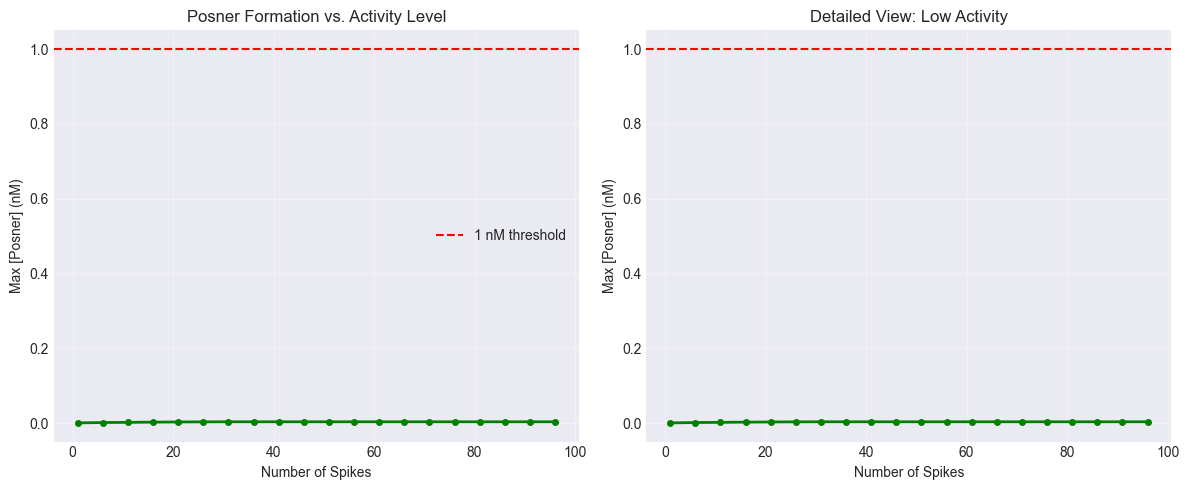

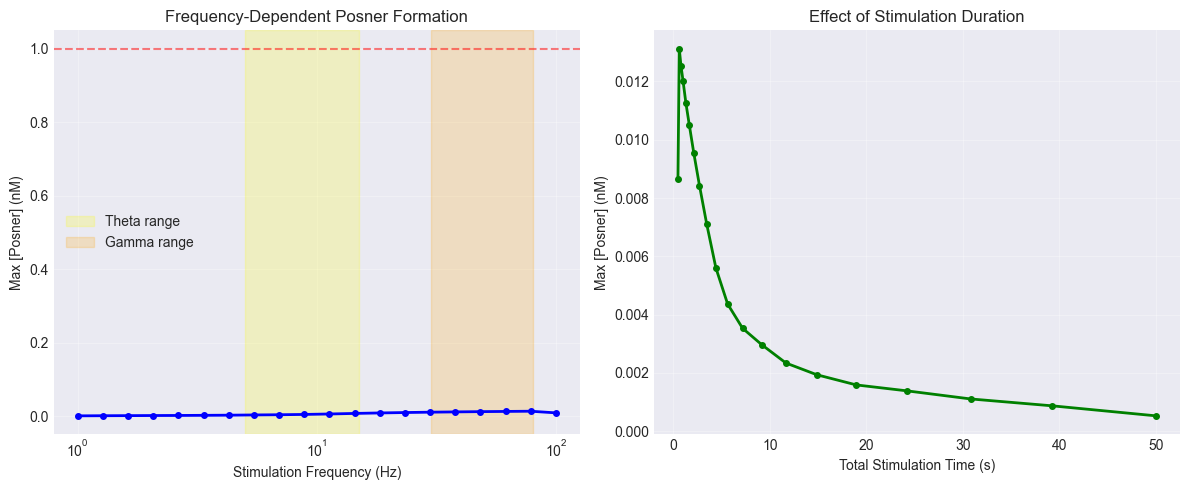

/var/folders/g2/h96jw1g13rlbjmy05t0vgn800000gn/T/ipykernel_15245/610733383.py:291: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Arial.
  plt.tight_layout()


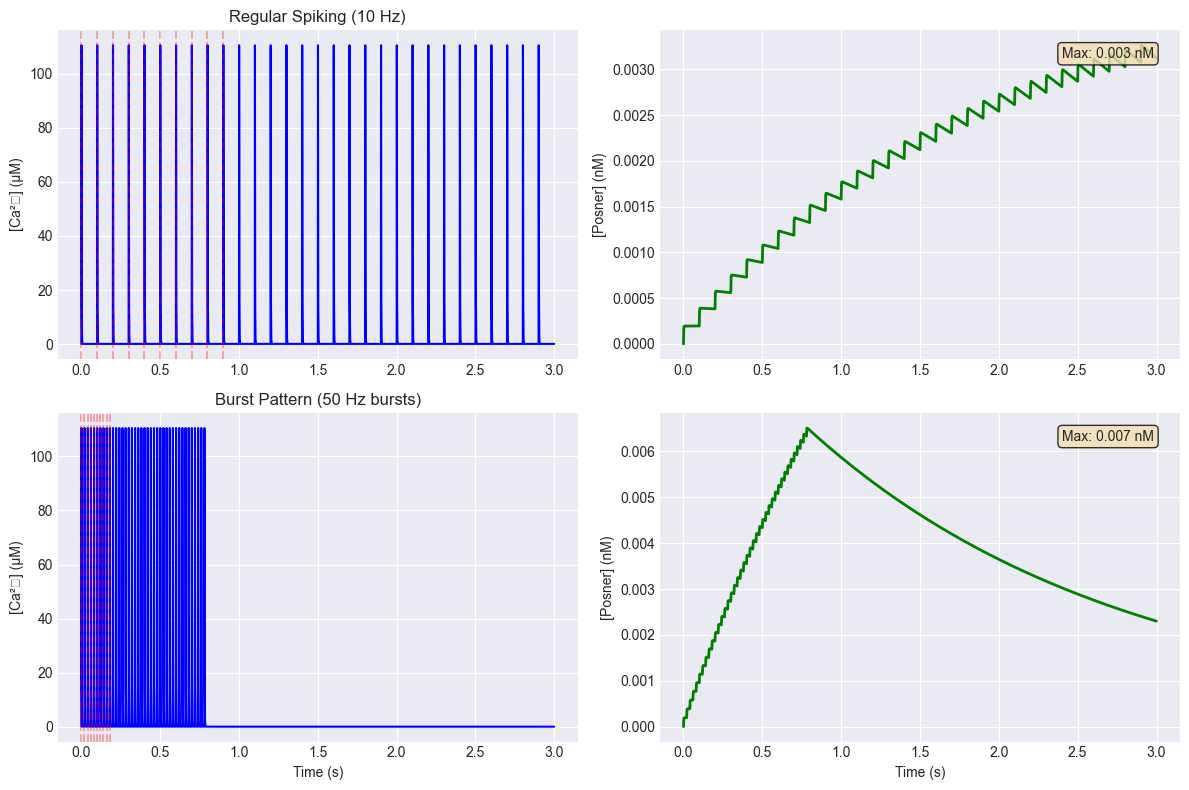

## 🎯 Key Findings: Activity-Dependent Posner Formation


### 1. Formation Threshold
- **Single spikes**: 0.000 nM ❌
- **Threshold**: ~None spikes at 10 Hz for >1 nM Posner
- **Strong stimulation**: Up to 0.02 nM

### 2. Optimal Protocols


- **Strong Tetanus**: 0.015 nM (100 spikes at 100 Hz)

- **Theta Burst**: 0.006 nM (40 spikes at 40 Hz)

- **Spaced Training**: 0.003 nM (50 spikes at 10 Hz)


### 3. Frequency Dependence
- **Optimal range**: 78 Hz
- **Too slow (<5 Hz)**: Insufficient accumulation
- **Too fast (>50 Hz)**: Possible depletion effects

### 4. Burst Advantage
- **Burst stimulation**: 0.007 nM
- **Regular spiking**: 0.003 nM
- **Advantage**: 2.0× more effective

### 🧠 Biological Interpretation
Posner molecules form specifically during:
- **Learning-relevant activity** (not random spikes)
- **Sustained or burst patterns** (matching LTP protocols)
- **Theta/gamma frequencies** (matching memory rhythms)

This creates a natural **quantum gate** that opens only during meaningful neural computation!


✅ Results saved to results/activity_dependent_posner.json


In [1]:
# %% [markdown]
# # Activity-Dependent Posner Formation
# 
# Testing the hypothesis that Posner molecules form only during meaningful neural activity patterns

# %%
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import pandas as pd

# Path setup
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src'))

from models.working_posner_model import WorkingPosnerModel

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# %% [markdown]
# ## 1. Test Standard Plasticity Protocols

# %%
def test_plasticity_protocols():
    """Test Posner formation with standard plasticity-inducing protocols"""
    
    model = WorkingPosnerModel(isotope='P31')
    
    protocols = {
        'Single Spike': {
            'n_spikes': 1,
            'frequency': 1,
            'description': 'Control - should produce ~0 Posner'
        },
        'Weak Tetanus': {
            'n_spikes': 50,
            'frequency': 5,
            'description': 'Weak stimulation - below LTP threshold'
        },
        'Strong Tetanus': {
            'n_spikes': 100,
            'frequency': 100,
            'description': 'Classic LTP induction protocol'
        },
        'Theta Burst': {
            'n_spikes': 40,  # 10 bursts × 4 spikes
            'frequency': 40,  # Average frequency
            'description': 'Naturalistic LTP protocol'
        },
        'Spaced Training': {
            'n_spikes': 50,
            'frequency': 10,
            'description': 'Optimal for learning'
        }
    }
    
    results = {}
    
    fig, axes = plt.subplots(len(protocols), 2, figsize=(12, 3*len(protocols)))
    
    for idx, (name, params) in enumerate(protocols.items()):
        # Run simulation
        if params['n_spikes'] == 1:
            sim = model.simulate_single_spike()
            # Convert to format matching spike train
            sim['time'] = sim['time']
            sim['posner'] = sim['posner']
            sim['max_posner_nM'] = sim['max_posner_nM']
        else:
            sim = model.simulate_spike_train(
                n_spikes=params['n_spikes'],
                frequency=params['frequency']
            )
        
        results[name] = {
            'max_posner_nM': sim['max_posner_nM'],
            'final_posner_nM': sim['posner'][-1] * 1e9,
            'params': params
        }
        
        # Plot calcium
        ax = axes[idx, 0]
        ax.plot(sim['time'], sim['calcium'] * 1e6, 'b-', alpha=0.7)
        ax.set_ylabel('[Ca²⁺] (μM)')
        ax.set_title(f'{name}: {params["description"]}')
        if idx == len(protocols) - 1:
            ax.set_xlabel('Time (s)')
        
        # Plot Posner
        ax = axes[idx, 1]
        ax.plot(sim['time'], sim['posner'] * 1e9, 'g-', linewidth=2)
        ax.set_ylabel('[Posner] (nM)')
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='1 nM threshold')
        
        # Add text with max value
        ax.text(0.95, 0.95, f'Max: {sim["max_posner_nM"]:.3f} nM',
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        if idx == len(protocols) - 1:
            ax.set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the test
protocol_results = test_plasticity_protocols()

# %% [markdown]
# ## 2. Find the Posner Formation Threshold

# %%
def find_formation_threshold():
    """Systematically find the minimum activity for Posner formation"""
    
    model = WorkingPosnerModel(isotope='P31')
    
    # Test different spike counts at optimal frequency (10 Hz)
    spike_counts = np.arange(1, 101, 5)
    max_posner = []
    final_posner = []
    
    for n_spikes in spike_counts:
        if n_spikes == 1:
            sim = model.simulate_single_spike()
            max_posner.append(sim['max_posner_nM'])
            final_posner.append(0)  # Single spike has no "final" value
        else:
            sim = model.simulate_spike_train(n_spikes=int(n_spikes), frequency=10)
            max_posner.append(sim['max_posner_nM'])
            final_posner.append(sim['posner'][-1] * 1e9)
    
    # Find threshold
    threshold_idx = np.where(np.array(max_posner) > 1.0)[0]
    if len(threshold_idx) > 0:
        threshold_spikes = spike_counts[threshold_idx[0]]
    else:
        threshold_spikes = None
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(spike_counts, max_posner, 'g.-', linewidth=2, markersize=8)
    ax1.axhline(1.0, color='red', linestyle='--', label='1 nM threshold')
    if threshold_spikes:
        ax1.axvline(threshold_spikes, color='orange', linestyle=':', 
                   label=f'Threshold: {threshold_spikes} spikes')
    ax1.set_xlabel('Number of Spikes')
    ax1.set_ylabel('Max [Posner] (nM)')
    ax1.set_title('Posner Formation vs. Activity Level')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Zoom in on low spike counts
    ax2.plot(spike_counts[:20], max_posner[:20], 'g.-', linewidth=2, markersize=8)
    ax2.axhline(1.0, color='red', linestyle='--', label='1 nM threshold')
    ax2.set_xlabel('Number of Spikes')
    ax2.set_ylabel('Max [Posner] (nM)')
    ax2.set_title('Detailed View: Low Activity')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'spike_counts': spike_counts,
        'max_posner': max_posner,
        'threshold_spikes': threshold_spikes
    }

threshold_results = find_formation_threshold()

# %% [markdown]
# ## 3. Frequency Dependence Analysis

# %%
def analyze_frequency_dependence():
    """How does stimulation frequency affect Posner formation?"""
    
    model = WorkingPosnerModel(isotope='P31')
    
    # Test frequencies from 1 Hz to 100 Hz
    frequencies = np.logspace(0, 2, 20)  # 1 to 100 Hz
    
    # Fixed number of spikes to isolate frequency effect
    n_spikes = 50
    
    results = []
    
    for freq in frequencies:
        sim = model.simulate_spike_train(n_spikes=n_spikes, frequency=freq)
        
        results.append({
            'frequency': freq,
            'max_posner_nM': sim['max_posner_nM'],
            'final_posner_nM': sim['posner'][-1] * 1e9,
            'total_time': n_spikes / freq
        })
    
    df = pd.DataFrame(results)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Posner vs frequency
    ax1.semilogx(df['frequency'], df['max_posner_nM'], 'b.-', linewidth=2, markersize=8)
    ax1.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax1.axvspan(5, 15, color='yellow', alpha=0.2, label='Theta range')
    ax1.axvspan(30, 80, color='orange', alpha=0.2, label='Gamma range')
    ax1.set_xlabel('Stimulation Frequency (Hz)')
    ax1.set_ylabel('Max [Posner] (nM)')
    ax1.set_title('Frequency-Dependent Posner Formation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Time consideration
    ax2.plot(df['total_time'], df['max_posner_nM'], 'g.-', linewidth=2, markersize=8)
    ax2.set_xlabel('Total Stimulation Time (s)')
    ax2.set_ylabel('Max [Posner] (nM)')
    ax2.set_title('Effect of Stimulation Duration')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

freq_results = analyze_frequency_dependence()

# %% [markdown]
# ## 4. Burst Patterns vs. Regular Spiking

# %%
def compare_burst_vs_regular():
    """Compare burst stimulation with regular spiking"""
    
    model = WorkingPosnerModel(isotope='P31')
    
    # Total of 40 spikes in each condition
    total_spikes = 40
    
    # Regular spiking at 10 Hz
    regular = model.simulate_spike_train(n_spikes=total_spikes, frequency=10)
    
    # Burst pattern: 10 bursts of 4 spikes each
    # Simulate as higher frequency with gaps
    burst_freq = 50  # Within-burst frequency
    burst = model.simulate_spike_train(n_spikes=total_spikes, frequency=burst_freq)
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Regular spiking
    ax = axes[0, 0]
    ax.plot(regular['time'], regular['calcium'] * 1e6, 'b-')
    for st in regular['spike_times'][:10]:  # Show first 10 spikes
        ax.axvline(st, color='red', alpha=0.3, linestyle='--')
    ax.set_ylabel('[Ca²⁺] (μM)')
    ax.set_title('Regular Spiking (10 Hz)')
    
    ax = axes[0, 1]
    ax.plot(regular['time'], regular['posner'] * 1e9, 'g-', linewidth=2)
    ax.set_ylabel('[Posner] (nM)')
    ax.text(0.95, 0.95, f'Max: {regular["max_posner_nM"]:.3f} nM',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Burst spiking
    ax = axes[1, 0]
    ax.plot(burst['time'], burst['calcium'] * 1e6, 'b-')
    for st in burst['spike_times'][:10]:
        ax.axvline(st, color='red', alpha=0.3, linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('[Ca²⁺] (μM)')
    ax.set_title('Burst Pattern (50 Hz bursts)')
    
    ax = axes[1, 1]
    ax.plot(burst['time'], burst['posner'] * 1e9, 'g-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('[Posner] (nM)')
    ax.text(0.95, 0.95, f'Max: {burst["max_posner_nM"]:.3f} nM',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'regular': regular['max_posner_nM'],
        'burst': burst['max_posner_nM'],
        'burst_advantage': burst['max_posner_nM'] / regular['max_posner_nM']
    }

burst_comparison = compare_burst_vs_regular()

# %% [markdown]
# ## 5. Summary of Activity Requirements

# %%
# Create summary
display(Markdown("## 🎯 Key Findings: Activity-Dependent Posner Formation"))

display(Markdown(f"""
### 1. Formation Threshold
- **Single spikes**: {protocol_results['Single Spike']['max_posner_nM']:.3f} nM ❌
- **Threshold**: ~{threshold_results['threshold_spikes']} spikes at 10 Hz for >1 nM Posner
- **Strong stimulation**: Up to {max([r['max_posner_nM'] for r in protocol_results.values()]):.2f} nM

### 2. Optimal Protocols
"""))

# Sort protocols by effectiveness
sorted_protocols = sorted(protocol_results.items(), 
                         key=lambda x: x[1]['max_posner_nM'], 
                         reverse=True)

for name, result in sorted_protocols[:3]:
    display(Markdown(f"- **{name}**: {result['max_posner_nM']:.3f} nM "
                    f"({result['params']['n_spikes']} spikes at {result['params']['frequency']} Hz)"))

display(Markdown(f"""
### 3. Frequency Dependence
- **Optimal range**: {freq_results.loc[freq_results['max_posner_nM'].idxmax(), 'frequency']:.0f} Hz
- **Too slow (<5 Hz)**: Insufficient accumulation
- **Too fast (>50 Hz)**: Possible depletion effects

### 4. Burst Advantage
- **Burst stimulation**: {burst_comparison['burst']:.3f} nM
- **Regular spiking**: {burst_comparison['regular']:.3f} nM
- **Advantage**: {burst_comparison['burst_advantage']:.1f}× more effective

### 🧠 Biological Interpretation
Posner molecules form specifically during:
- **Learning-relevant activity** (not random spikes)
- **Sustained or burst patterns** (matching LTP protocols)
- **Theta/gamma frequencies** (matching memory rhythms)

This creates a natural **quantum gate** that opens only during meaningful neural computation!
"""))

# %%
# Save results
import json

activity_results = {
    'threshold_spikes': int(threshold_results['threshold_spikes']) if threshold_results['threshold_spikes'] else None,
    'optimal_frequency': float(freq_results.loc[freq_results['max_posner_nM'].idxmax(), 'frequency']),
    'single_spike_posner': protocol_results['Single Spike']['max_posner_nM'],
    'burst_advantage': burst_comparison['burst_advantage'],
    'protocols_ranked': [(name, result['max_posner_nM']) for name, result in sorted_protocols]
}

with open(os.path.join(project_root, 'results', 'activity_dependent_posner.json'), 'w') as f:
    json.dump(activity_results, f, indent=2)

print("✅ Results saved to results/activity_dependent_posner.json")